# Natural Language Processing: SMS Spam Collection processing

#### A collection of around 5000 sms there is in a file csv  'SMSSpamCollection' under folder of 'smsspamcollection' . we're going to read this file and do some string processes on it, and apply some machine learning techniques via scikit learn library.

In [2]:
import numpy as np
import pandas as pd

first open sms file via following code:

In [3]:
messages=[line.rstrip() for line in open('smsspamcollection/SMSSpamCollection')]

the messages are so close to each other, so we can enumerate them through following code:

In [8]:
for x,y in enumerate(messages[:10]):
    print(x,y, '\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat... 

1 ham	Ok lar... Joking wif u oni... 

2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's 

3 ham	U dun say so early hor... U c already then say... 

4 ham	Nah I don't think he goes to usf, he lives around here though 

5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, آ£1.50 to rcv 

6 ham	Even my brother is not like to speak with me. They treat me like aids patent. 

7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune 

8 spam	WINNER!! As a valued network customer you have been selected to receivea آ£900 prize reward! To claim call 09061701461. Claim cod

now we're going to read smses in a dataframe named messages, separated message and label with names: label( ham or spam) , and message itself: 

In [22]:
messages=pd.read_csv('smsspamcollection/SMSSpamCollection',sep='\t',names=['label','message'])

In [23]:
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's check out some of the stats with some plots and the built-in methods in pandas!

In [25]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's use groupby to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [27]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of feature engineering. The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general.

add a new column named, length indicating number of each sms's characters:

In [31]:
messages['length']=messages['message'].apply(len)

In [32]:
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization
Let's visualize this! Let's do the imports:

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

draw a histogram based on length:

<AxesSubplot:ylabel='Frequency'>

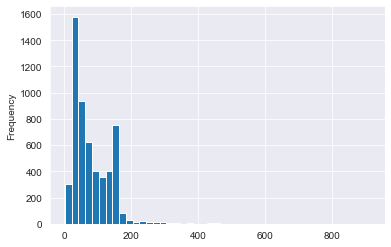

In [38]:
sns.set_style('darkgrid')
messages['length'].plot(kind='hist',bins=45)#pandas built in method

Play around with the bin size! Looks like text length may be a good feature to think about! Let's try to explain why the x-axis goes all the way to 1000ish, this must mean that there is some really long message!

In [41]:
messages.length.describe()

count    5572.000000
mean       80.489950
std        59.942907
min         2.000000
25%        36.000000
50%        62.000000
75%       122.000000
max       910.000000
Name: length, dtype: float64

Woah! 910 characters, let's use masking to find this message:

In [46]:
messages['message'][messages['length']==messages['length'].max()]

1085    For me the love should start with attraction.i...
Name: message, dtype: object

Looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

array([<AxesSubplot:title={'center':'ham'}>,
       <AxesSubplot:title={'center':'spam'}>], dtype=object)

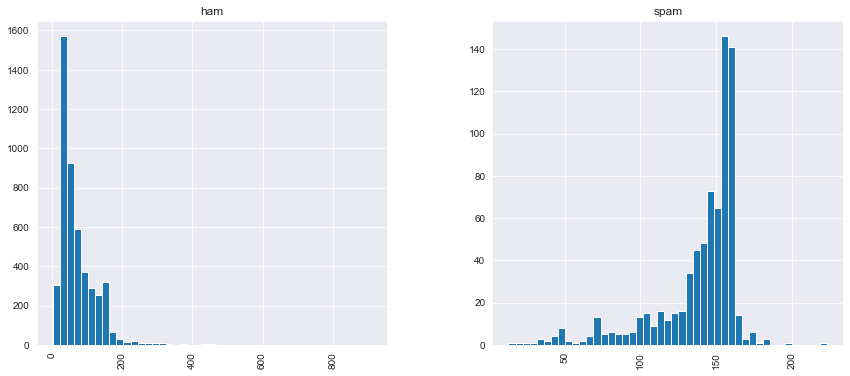

In [55]:
messages.hist(column='length',by='label',bins=45,figsize=(14,6))

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters. (Sorry Romeo!)

Now let's begin to process the data so we can eventually use it with SciKit Learn!

# Text Pre-processing
Our main issue with our data is that it is all in text format (strings). The classification algorithms that we've learned about so far will need some sort of numerical feature vector in order to perform the classification task. There are actually many methods to convert a corpus to a vector format. The simplest is the the bag-of-words approach, where each unique word in a text will be represented by one number.

In this section we'll convert the raw messages (sequence of characters) into vectors (sequences of numbers).

As a first step, let's write a function that will split a message into its individual words and return a list. We'll also remove very common words, ('the', 'a', etc..). To do this we will take advantage of the NLTK library. It's pretty much the standard library in Python for processing text and has a lot of useful features. We'll only use some of the basic ones here.

Let's create a function that will process the string in the message column, then we can just use apply() in pandas do process all the text in the DataFrame.

First removing punctuation. We can just take advantage of Python's built-in string library to get a quick list of all the possible punctuation:

In [61]:
import string

In [62]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [70]:
from nltk.corpus import stopwords
stopw=stopwords.words('english')

In [79]:
def cleantxt(txt):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc=[s for s in txt if s not in string.punctuation]
    # Join the characters again to form the string.
    nopunc=''.join(nopunc)
    # Now just remove any stopwords
    return [s for s in nopunc.split() if s.lower() not in stopw]

Now let's "tokenize" these messages. Tokenization is just the term used to describe the process of converting the normal text strings in to a list of tokens (words that we actually want).

Let's see an example output on on column:

**Note:**
We may get some warnings or errors for symbols we didn't account for or that weren't in Unicode (like a British pound symbol)

In [81]:
# Check to make sure its working
messages['message'].head(5).apply(cleantxt)

0    [Go, jurong, point, crazy, Available, bugis, n...
1                       [Ok, lar, Joking, wif, u, oni]
2    [Free, entry, 2, wkly, comp, win, FA, Cup, fin...
3        [U, dun, say, early, hor, U, c, already, say]
4    [Nah, dont, think, goes, usf, lives, around, t...
Name: message, dtype: object

# Vectorization 
Currently, we have the messages as lists of tokens (also known as [lemmas](http://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html)) and now we need to convert each of those messages into a vector the SciKit Learn's algorithm models can work with.

Now we'll convert each message, represented as a list of tokens (lemmas) above, into a vector that machine learning models can understand.

We'll do that in three steps using the bag-of-words model:

1. Count how many times does a word occur in each message (Known as term frequency)

2. Weigh the counts, so that frequent tokens get lower weight (inverse document frequency)

3. Normalize the vectors to unit length, to abstract from the original text length (L2 norm)

Let's begin the first step:
<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>
Since there are so many messages, we can expect a lot of zero counts for the presence of that word in that document. Because of this, SciKit Learn will output a [Sparse Matrix] (https://en.wikipedia.org/wiki/Sparse_matrix).

In [89]:
from sklearn.feature_extraction.text import CountVectorizer

There are a lot of arguments and parameters that can be passed to the CountVectorizer. In this case we will just specify the **analyzer** to be our own previously defined function:

In [85]:
messages_fittedTo_CV=CountVectorizer(analyzer=cleantxt).fit(messages['message'])
tranformed_messages=messages_fittedTo_CV.transform(messages['message'])

In [86]:
print('sparse matrix Shape:   '+str(tranformed_messages.shape))
print('number of nonzeroes:   '+str(tranformed_messages.nnz))

sparse matrix Shape:   (5572, 11425)
number of nonzeroes:   50548


In [87]:
print(len(messages_fittedTo_CV.vocabulary_))

11425


In [88]:
print(messages_fittedTo_CV.get_feature_names_out())

['0' '008704050406' '0089my' ... '“Harry' '…' '…Thanks']


In [90]:
mess_fittedTo_CV.get_feature_names_out()[9876]

'shakara'

In [93]:
sparsity=(100*tranformed_messages.nnz/(tranformed_messages.shape[0]*tranformed_messages.shape[1]))

In [94]:
print(sparsity)

0.07940295412668218


now we're going to focus on TF-IDF that gives us a weight for each term in the document that is indicating importance of that term in that document.

In [96]:
from sklearn.feature_extraction.text import TfidfTransformer

In [101]:
Tfidf_T=TfidfTransformer().fit(tranformed_messages)

In [103]:
Transformed_Tfidf_T=Tfidf_T.transform(tranformed_messages)

We'll go ahead and check what is the IDF (inverse document frequency) of the word `"u"` and of word `"university"`?

In [107]:
Tfidf_T.idf_[messages_fittedTo_CV.vocabulary_['university']]

8.527076498901426

In [121]:
Tfidf_T.idf_[messages_fittedTo_CV.vocabulary_['u']]

3.2800524267409408

In [124]:
Tfidf_T.idf_# weights for all terms in Bag_Of_Words(messages_fittedto_CV)

array([8.23939443, 8.5270765 , 8.93254161, ..., 8.93254161, 6.98663146,
       8.93254161])

In [118]:
print(Transformed_Tfidf_T.shape)

(5572, 11425)


There are many ways the data can be preprocessed and vectorized. These steps involve feature engineering and building a "pipeline". Now we'll focus on a model training below.

## Training a model

With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a variety of reasons, the Naive Bayes classifier algorithm is a good choice.

In [119]:
from sklearn.naive_bayes  import MultinomialNB

In [138]:
guess_spam_ham=MultinomialNB().fit(Transformed_Tfidf_T,messages['label'])

In [142]:
messages['predicted_spam_ham']=pd.Series(guess_spam_ham.predict(Transformed_Tfidf_T))

In [147]:
len(messages[messages['label']!=messages['predicted_spam_ham']])

115

wow! Fantastic! We've developed a model that can attempt to predict spam vs ham classification! 

it's interesting... we predicted correctly 5572-115=5457 label and just 115 incorrect.

We can use SciKit Learn's built-in classification report, which returns precision, recall,f1-score, and a column for support (meaning how many cases supported that classification).

In [148]:
from sklearn.metrics import classification_report

In [149]:
print(classification_report(messages['predicted_spam_ham'],messages['label']))

              precision    recall  f1-score   support

         ham       1.00      0.98      0.99      4940
        spam       0.85      1.00      0.92       632

    accuracy                           0.98      5572
   macro avg       0.92      0.99      0.95      5572
weighted avg       0.98      0.98      0.98      5572



In the above "evaluation",we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.

## Train Test Split

In [164]:
from sklearn.model_selection import train_test_split

In [175]:
messages_train,messages_test,label_train,label_test=train_test_split(messages['message'],messages['label'],test_size=0.3)

In [176]:
print(len(messages_train),len(messages_test),len(label_train)+len(label_test))

3900 1672 5572


The test size is 20% of the entire dataset (1115 messages out of total 5572), and the training is the rest (4457 out of 5572). Note the default split would have been 30/70.

## Creating a Data Pipeline

Let's run our model again and then predict off the test set. We will use SciKit Learn's pipeline capabilities to store a pipeline of workflow. This will allow us to set up all the transformations that we will do to the data for future use. Let's see an example of how it works:

In [177]:
from sklearn.pipeline import Pipeline

In [186]:
pipeline=Pipeline([('BagOfWords',CountVectorizer(analyzer=cleantxt)),('tfidf',TfidfTransformer()),('classifier',MultinomialNB())])

Now we can directly pass message text data and the pipeline will do our pre-processing for us! We can treat it as a model/estimator API:

In [187]:
pipeline.fit(messages_train,label_train)

Pipeline(steps=[('BagOfWords',
                 CountVectorizer(analyzer=<function cleantxt at 0x000002580AEFEEE0>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [189]:
predictions=pipeline.predict(messages_test)

In [190]:
print(classification_report(predictions,label_test))

              precision    recall  f1-score   support

         ham       1.00      0.97      0.98      1505
        spam       0.78      1.00      0.87       167

    accuracy                           0.97      1672
   macro avg       0.89      0.98      0.93      1672
weighted avg       0.98      0.97      0.97      1672



Now we have a classification report for our model on a true testing set! There is a lot more to Natural Language Processing than what we've covered here, and its vast expanse of topic could fill up several college courses! 

# I hope you have enjoyed this project. let's go for other projects:)